**Raw files links**

https://drive.google.com/drive/folders/1L8ew_IZLAsi4XCd1_a8BOo-rUvdcRD2o?usp=sharing

https://drive.google.com/drive/folders/1mbV9_iXbZOtbhBHi-mt9XhvgIL9LYOR8?usp=sharing


### Importación de librerías

In [5]:
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import IPython
import gc
import torch.nn.functional as F
import torchaudio.transforms as tt
import matplotlib
import matplotlib.pyplot as plt
import wandb
import random
import torch.optim as optim
import torchaudio.transforms as T

from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from typing import Dict
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torchaudio.sox_effects import apply_effects_tensor
from typing import Optional

%matplotlib inline

In [6]:
# Antes de los experimentos
os.environ['WANDB_REPOSITORY'] = "TP3_TD6"
os.environ['WANDB_BRANCH'] = "main"

wandb.login(key = "8d8ef134d9fd4e507ac225c63d5b5a4d09be9860")


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
# Definir el sample rate
samplerate = 22050

### Clases

In [8]:
class ToSpectrogram(nn.Module):
    def __init__(self):
        super().__init__()
        self.spectrogram = tt.Spectrogram()

    def forward(self, waveform):
        return self.spectrogram(waveform)

# Transformaciones personalizadas
class PadOrTruncate:
    def __init__(self, fixed_length=110250):
        self.fixed_length = fixed_length

    def __call__(self, waveform):
        current_length = waveform.size(1)
        if current_length > self.fixed_length:
            waveform = waveform[:, :self.fixed_length]
        elif current_length < self.fixed_length:
            padding = self.fixed_length - current_length
            waveform = F.pad(waveform, (0, padding))
        return waveform

# Normalización de audio
class NormalizeAudio(nn.Module):
    def __init__(self, mean=0.0, std=1.0):
        super(NormalizeAudio, self).__init__()
        self.mean = mean
        self.std = std

    def forward(self, waveform):
        return (waveform - self.mean) / self.std

# Transformación de TimeStretch en la forma de onda usando SoX
class TimeStretchWaveform(nn.Module):
    def __init__(self, rate: float = 1.2):
        super(TimeStretchWaveform, self).__init__()
        self.rate = rate

    def forward(self, waveform: torch.Tensor, sample_rate: int = samplerate) -> torch.Tensor:
        effects = [
            ['tempo', f'{self.rate}']
        ]
        # Aplicar efectos de SoX
        waveform, _ = apply_effects_tensor(waveform, sample_rate, effects)
        return waveform

# Transformación de PitchShift en la forma de onda usando SoX
class PitchShiftWaveform(nn.Module):
    def __init__(self, n_steps: int = 2):
        super(PitchShiftWaveform, self).__init__()
        self.n_steps = n_steps

    def forward(self, waveform: torch.Tensor, sample_rate: int = samplerate) -> torch.Tensor:
        effects = [
            ['pitch', f'{self.n_steps * 100}'],  # Cada step corresponde a 100 cents
            ['rate', f'{sample_rate}']  # Mantener el sample rate original
        ]
        # Aplicar efectos de SoX
        waveform, _ = apply_effects_tensor(waveform, sample_rate, effects)
        return waveform

# Opcional: Resamplear si es necesario
class ResampleWaveform(nn.Module):
    def __init__(self, orig_freq: int, new_freq: int):
        super(ResampleWaveform, self).__init__()
        self.resample = torchaudio.transforms.Resample(orig_freq=orig_freq, new_freq=new_freq)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        return self.resample(waveform)

class AddNoise(nn.Module):
    def __init__(self, noise_level=0.005):
        super(AddNoise, self).__init__()
        self.noise_level = noise_level

    def forward(self, spectrogram: torch.Tensor) -> torch.Tensor:
        noise = torch.randn_like(spectrogram) * self.noise_level
        return spectrogram + noise

# Dataset
class MusicDataset(Dataset):
    def __init__(self, root='/content/drive/MyDrive/TP3_TD6/genres_5sec/', transform=None, samplerate=22050):
        super().__init__()
        self.root = root
        self.files = []
        self.classes = self.get_classes(self.root)
        for c in self.classes:
            class_dir = os.path.join(root, c)
            for fname in os.listdir(class_dir):
                if fname.endswith('.wav'):
                    self.files.append((c, fname))
        # Ordenar las clases para tener índices consistentes
        self.classes = sorted(self.classes)
        self.transform = transform
        self.samplerate = samplerate  # Guardar samplerate como atributo de la instancia

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        genre, fname = self.files[idx]
        fpath = os.path.join(self.root, genre, fname)
        class_idx = self.classes.index(genre)
        waveform, sample_rate = torchaudio.load(fpath)

        # Convertir a mono si tiene múltiples canales
        if waveform.size(0) > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resamplear si es necesario
        if sample_rate != self.samplerate:
            resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.samplerate)
            waveform = resample_transform(waveform)
            sample_rate = self.samplerate

        # Asegurar que la forma de onda tenga una longitud fija (ejemplo: 5 segundos)
        fixed_length = self.samplerate * 5  # 5 segundos
        if waveform.size(1) > fixed_length:
            waveform = waveform[:, :fixed_length]
        elif waveform.size(1) < fixed_length:
            padding = fixed_length - waveform.size(1)
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, class_idx

    def get_classes(self, root):
        list_files = os.listdir(root)
        classes = []
        for file in list_files:
            name = os.path.join(root, file)
            if os.path.isdir(name):
                classes.append(file)
        return classes

# Early Stopping
class EarlyStopping:
    """
    Early stopping para detener el entrenamiento cuando la pérdida de validación deja de mejorar.
    """
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class MLP2(nn.Module):
    def __init__(self, n_input, nodes_list, n_output=10, dropout_p=0.0, dense_layers=2):
        super(MLP2, self).__init__()

        self.dense_layers = nn.ModuleList()
        in_features = n_input

        for i in range(dense_layers):
            nodes = nodes_list[i] if i < len(nodes_list) else nodes_list[-1]
            layers = [
                nn.Linear(in_features, nodes),
                nn.BatchNorm1d(nodes),
                nn.ReLU()
            ]
            if dropout_p > 0.0:
                layers.append(nn.Dropout(p=dropout_p))
            layer = nn.Sequential(*layers)
            self.dense_layers.append(layer)
            in_features = nodes

        self.output = nn.Linear(in_features, n_output)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        for layer in self.dense_layers:
            x = layer(x)

        x = self.output(x)
        return F.log_softmax(x, dim=1)


class CEL_w(nn.Module):
    def __init__(self, n_input=110250, nodes_list=[64, 128], n_output=10, dropout_prob=0.3, dense_layers=2):
        super(CEL_w, self).__init__()

        self.conv_layers = nn.ModuleList()
        in_channels = 1
        for nodes in nodes_list:
            conv_block = nn.Sequential(
                nn.Conv1d(in_channels, nodes, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm1d(nodes),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
                nn.Dropout1d(dropout_prob)
            )
            self.conv_layers.append(conv_block)
            in_channels = nodes

        # Tamaño de la salida de convoluciones 1D
        self.flatten_size = nodes_list[-1] * (n_input // (2 ** len(nodes_list)))

        # Capas densas
        self.dense_layers = nn.ModuleList()
        in_features = self.flatten_size
        for i in range(dense_layers):
            out_features = n_output if i == dense_layers - 1 else nodes_list[-1]
            dense_block = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.ReLU() if i < dense_layers - 1 else nn.Identity(),
                nn.Dropout(dropout_prob) if i < dense_layers - 1 else nn.Identity()
            )
            self.dense_layers.append(dense_block)
            in_features = out_features

    def forward(self, x):
        for conv_block in self.conv_layers:
            x = conv_block(x)
        x = x.view(x.size(0), -1)  # Flatten para la capa densa
        for dense_block in self.dense_layers:
            x = dense_block(x)
        return F.log_softmax(x, dim=1)

class CEL_s(nn.Module):
    def __init__(self, n_input_height=201, n_input_width=552, nodes_list=[32, 64], n_output=10, dropout_prob=0.3, dense_layers=2):
        super(CEL_s, self).__init__()

        self.conv_layers = nn.ModuleList()
        in_channels = 1
        for nodes in nodes_list:
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels, nodes, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(nodes),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout2d(dropout_prob)
            )
            self.conv_layers.append(conv_block)
            in_channels = nodes

        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, n_input_height, n_input_width)
            x = dummy_input
            for layer in self.conv_layers:
                x = layer(x)
            self.flatten_size = x.numel()

        self.dense_layers = nn.ModuleList()
        in_features = self.flatten_size
        for i in range(dense_layers):
            out_features = n_output if i == dense_layers - 1 else nodes_list[-1]
            dense_block = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.ReLU() if i < dense_layers - 1 else nn.Identity(),
                nn.Dropout(dropout_prob) if i < dense_layers - 1 else nn.Identity()
            )
            self.dense_layers.append(dense_block)
            in_features = out_features

    def forward(self, x):
        for conv_block in self.conv_layers:
            x = conv_block(x)
        x = x.view(x.size(0), -1)
        for dense_block in self.dense_layers:
            x = dense_block(x)
        return F.log_softmax(x, dim=1)

class CEL2_w(nn.Module):
    def __init__(self, n_input=110250, nodes_list=[64, 128], n_output=10, dropout_prob=0.3, dense_layers=2):
        super(CEL2_w, self).__init__()

        self.conv_layers = nn.ModuleList()
        in_channels = 1
        for nodes in nodes_list:
            conv_block = nn.Sequential(
                nn.Conv1d(in_channels, nodes, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm1d(nodes),
                nn.LeakyReLU(),
                nn.MaxPool1d(kernel_size=2),
                nn.Dropout1d(dropout_prob)
            )
            self.conv_layers.append(conv_block)
            in_channels = nodes


        self.flatten_size = nodes_list[-1] * (n_input // (2 ** len(nodes_list)))

        # Capas densas
        self.dense_layers = nn.ModuleList()
        in_features = self.flatten_size
        for i in range(dense_layers):
            out_features = n_output if i == dense_layers - 1 else nodes_list[-1]
            dense_block = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.LeakyReLU() if i < dense_layers - 1 else nn.Identity(),
                nn.Dropout(dropout_prob) if i < dense_layers - 1 else nn.Identity()
            )
            self.dense_layers.append(dense_block)
            in_features = out_features

    def forward(self, x):
        for conv_block in self.conv_layers:
            x = conv_block(x)
        x = x.view(x.size(0), -1)
        for dense_block in self.dense_layers:
            x = dense_block(x)
        return F.log_softmax(x, dim=1)


class CEL2_s(nn.Module):
    def __init__(self, n_input_height=201, n_input_width=552, nodes_list=[32, 64], n_output=10, dropout_prob=0.3, dense_layers=2):
        super(CEL2_s, self).__init__()

        self.conv_layers = nn.ModuleList()
        in_channels = 1
        for nodes in nodes_list:
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels, nodes, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(nodes),
                nn.LeakyReLU(),  # Cambiado de ReLU a LeakyReLU
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout2d(dropout_prob)
            )
            self.conv_layers.append(conv_block)
            in_channels = nodes

        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, n_input_height, n_input_width)
            x = dummy_input
            for layer in self.conv_layers:
                x = layer(x)
            self.flatten_size = x.numel()

        self.dense_layers = nn.ModuleList()
        in_features = self.flatten_size
        for i in range(dense_layers):
            out_features = n_output if i == dense_layers - 1 else nodes_list[-1]
            dense_block = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.LeakyReLU() if i < dense_layers - 1 else nn.Identity(),  # Cambiado de ReLU a LeakyReLU
                nn.Dropout(dropout_prob) if i < dense_layers - 1 else nn.Identity()
            )
            self.dense_layers.append(dense_block)
            in_features = out_features

    def forward(self, x):
        for conv_block in self.conv_layers:
            x = conv_block(x)
        x = x.view(x.size(0), -1)
        for dense_block in self.dense_layers:
            x = dense_block(x)
        return F.log_softmax(x, dim=1)

class CEL3_w(nn.Module):
  def __init__(self, n_input=110250, nodes_list=[64, 128], n_output=10, dropout_prob=0.3, dense_layers=2):
      super(CEL3_w, self).__init__()

      self.conv_layers = nn.ModuleList()
      in_channels = 1
      for nodes in nodes_list:
          conv_block = nn.Sequential(
              nn.Conv1d(in_channels, nodes, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm1d(nodes),
              nn.ELU(),  # Cambiado de ReLU a ELU
              nn.MaxPool1d(kernel_size=2),
              nn.Dropout1d(dropout_prob)
          )
          self.conv_layers.append(conv_block)
          in_channels = nodes

      # Tamaño de la salida de convoluciones 1D
      self.flatten_size = nodes_list[-1] * (n_input // (2 ** len(nodes_list)))

      # Capas densas
      self.dense_layers = nn.ModuleList()
      in_features = self.flatten_size
      for i in range(dense_layers):
          out_features = n_output if i == dense_layers - 1 else nodes_list[-1]
          dense_block = nn.Sequential(
              nn.Linear(in_features, out_features),
              nn.ELU() if i < dense_layers - 1 else nn.Identity(),  # Cambiado de ReLU a ELU
              nn.Dropout(dropout_prob) if i < dense_layers - 1 else nn.Identity()
          )
          self.dense_layers.append(dense_block)
          in_features = out_features

  def forward(self, x):
      for conv_block in self.conv_layers:
          x = conv_block(x)
      x = x.view(x.size(0), -1)  # Flatten para la capa densa
      for dense_block in self.dense_layers:
          x = dense_block(x)
      return F.log_softmax(x, dim=1)

class CEL3_s(nn.Module):
    def __init__(self, n_input_height=201, n_input_width=552, nodes_list=[32, 64], n_output=10, dropout_prob=0.3, dense_layers=2):
        super(CEL3_s, self).__init__()

        self.conv_layers = nn.ModuleList()
        in_channels = 1
        for nodes in nodes_list:
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels, nodes, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(nodes),
                nn.ELU(),  # Cambiado de ReLU a ELU
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout2d(dropout_prob)
            )
            self.conv_layers.append(conv_block)
            in_channels = nodes

        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, n_input_height, n_input_width)
            x = dummy_input
            for layer in self.conv_layers:
                x = layer(x)
            self.flatten_size = x.numel()

        self.dense_layers = nn.ModuleList()
        in_features = self.flatten_size
        for i in range(dense_layers):
            out_features = n_output if i == dense_layers - 1 else nodes_list[-1]
            dense_block = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.ELU() if i < dense_layers - 1 else nn.Identity(),  # Cambiado de ReLU a ELU
                nn.Dropout(dropout_prob) if i < dense_layers - 1 else nn.Identity()
            )
            self.dense_layers.append(dense_block)
            in_features = out_features

    def forward(self, x):
        for conv_block in self.conv_layers:
            x = conv_block(x)
        x = x.view(x.size(0), -1)
        for dense_block in self.dense_layers:
            x = dense_block(x)
        return F.log_softmax(x, dim=1)

### Funciones

In [9]:
# plot spectrogram
def plot_spectrogram(spectrogram, title="Spectrogram", transformed=False):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram.log2().numpy(), cmap='viridis', aspect='auto')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    if transformed:
        plt.title(f"Transformed {title}")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

# plot waveforms
def plot_waveform(waveform, sample_rate, title="Waveform", transformed=False):
    plt.figure(figsize=(10, 4))
    plt.plot(waveform.t().numpy())
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    if transformed:
        plt.title(f"Transformed {title}")
    plt.show()

# Parseo de géneros
def parse_genres(fname):
    """
    Extrae el nombre del género musical a partir del nombre del archivo.

    Args:
        fname (str): Ruta completa del archivo.

    Returns:
        str: Nombre del género extraído del archivo.
    """
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

# Obtener clases
def classes(root = '/content/drive/MyDrive/TP3_TD6/genres_5sec'):
    """
    Lista todas las clases de géneros musicales presentes en el directorio especificado.

    Args:
        root (str, opcional): Ruta al directorio raíz que contiene las carpetas de géneros. Por defecto es './genres_5sec'.

    Returns:
        list: Lista de nombres de clases (géneros musicales).
    """
    list_files = os.listdir(root)
    classes = []
    for file in list_files:
        name = f'{root}/{file}'
        if os.path.isdir(name):
            classes.append(file)
    return classes


# Stratify split
def stratify_split(dataset: Dataset, classes: list[int], transforms: Dict[str, nn.Module] = {'train': None, 'val': None, 'test': None}) -> tuple[Subset, Subset, Subset]:
    """
    Divide el dataset en conjuntos de entrenamiento, validación y prueba de manera estratificada.

    Args:
        dataset (Dataset): Dataset completo que contiene los datos y etiquetas.
        classes (list[int]): Lista de índices de clases presentes en el dataset.
        transforms (Dict[str, nn.Module], opcional): Transformaciones a aplicar a cada subconjunto. Por defecto es {'train': None, 'val': None, 'test': None}.

    Returns:
        tuple[Subset, Subset, Subset]: Tupla que contiene los subconjuntos de entrenamiento, validación y prueba.
    """

    train_indices = []
    val_indices = []
    test_indices = []

    NUM_CLASSES = len(classes)
    total_samples = len(dataset)

    # Calcular el número de muestras para cada conjunto
    train_samples = int(total_samples * 0.8)
    val_samples = int(total_samples * 0.1)
    test_samples = total_samples - train_samples - val_samples  # Resto para test

    train_samples_per_class = train_samples // NUM_CLASSES
    val_samples_per_class = val_samples // NUM_CLASSES
    test_samples_per_class = test_samples // NUM_CLASSES

    train_target_counter = collections.Counter()
    val_target_counter = collections.Counter()
    test_target_counter = collections.Counter()

    for idx, data in enumerate(dataset):
        target = data[1]
        if train_target_counter[target] < train_samples_per_class:
            train_indices.append(idx)
            train_target_counter[target] += 1
        elif val_target_counter[target] < val_samples_per_class:
            val_target_counter[target] += 1
            val_indices.append(idx)
        elif test_target_counter[target] < test_samples_per_class:
            test_target_counter[target] += 1
            test_indices.append(idx)


    if transforms is not None:
      train_dataset = Subset(
          MusicDataset(root=dataset.root, transform=transforms['train']),
          train_indices
      )

      val_dataset = Subset(
          MusicDataset(root=dataset.root, transform=transforms['val']),
          val_indices
      )

      test_dataset = Subset(
          MusicDataset(root=dataset.root, transform=transforms['test']),
          test_indices
      )

      return train_dataset, val_dataset, test_dataset

def count_parameters(model):
    """
    Cuenta el número de parámetros entrenables en un modelo.

    Args:
        model: Modelo de PyTorch cuyo número de parámetros se desea contar.

    Returns:
        int: Número total de parámetros entrenables.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Configuración para probar diferentes optimizadores
def get_optimizer(optimizer_name, model, lr):
    """
    Retorna el optimizador de PyTorch basado en el nombre proporcionado.

    Args:
        optimizer_name (str): Nombre del optimizador ('adam', 'adamw', 'sgd', etc.).
        model: Modelo de PyTorch cuyos parámetros serán optimizados.
        lr (float): Tasa de aprendizaje para el optimizador.

    Returns:
        torch.optim.Optimizer: Instancia del optimizador seleccionado.
    """
    if optimizer_name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        return torch.optim.Adam(model.parameters(), lr=lr)

def get_scheduler(scheduler_name, optimizer, num_epochs, trainloader):
    """
    Retorna el scheduler de PyTorch basado en el nombre proporcionado.

    Args:
        scheduler_name (str): Nombre del scheduler ('plateau', 'cosine', 'step', 'onecycle', 'warmrestarts', etc.).
        optimizer (torch.optim.Optimizer): Optimizador para el cual se aplicará el scheduler.
        num_epochs (int): Número total de épocas de entrenamiento.
        trainloader (DataLoader): DataLoader del conjunto de entrenamiento.

    Returns:
        torch.optim.lr_scheduler._LRScheduler o None: Instancia del scheduler seleccionado o None si no se especifica.
    """
    if scheduler_name.lower() == 'plateau':
        return torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3
        )
    elif scheduler_name.lower() == 'cosine':
        return torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=num_epochs, eta_min=1e-6
        )
    else:
        return None

def l1_regularization(model, lambda_l1=0.01):
    """
    Aplica regularización L1 al modelo.

    Args:
        model: Modelo PyTorch
        lambda_l1: Factor de regularización L1

    Returns:
        torch.Tensor: Término de regularización L1
    """
    l1_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l1_reg = l1_reg + torch.norm(param, 1)
    return lambda_l1 * l1_reg

def l2_regularization(model, lambda_l2=0.01):
    """
    Aplica regularización L2 al modelo.

    Args:
        model: Modelo PyTorch
        lambda_l2: Factor de regularización L2

    Returns:
        torch.Tensor: Término de regularización L2
    """
    l2_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l2_reg = l2_reg + torch.norm(param, 2)
    return lambda_l2 * l2_reg

def train_model_w(model_name, device, hyperparameter_configs, dataset, train_dataset, val_dataset, n_input, by='waveform',
                scheduler_name='None', optimizer_name='adam', regularization_type=None, lambda_reg=0.01, early_stopping_patience=None):
    """
    Entrena el modelo especificado con las configuraciones de hiperparámetros proporcionadas.

    Args:
        model_name (str): Nombre del modelo a entrenar ('MLP2', 'CEL_w', 'MLP', etc.).
        num_epochs (int): Número de épocas para el entrenamiento.
        device (torch.device): Dispositivo donde se realizará el entrenamiento (CPU o GPU).
        hyperparameter_configs (list of dict): Lista de configuraciones de hiperparámetros para probar.
        dataset: Dataset completo que contiene los datos y etiquetas.
        train_dataset (Subset): Subconjunto de entrenamiento.
        val_dataset (Subset): Subconjunto de validación.
        n_input (int): Tamaño de la entrada para el modelo.
        by (tuple): Información adicional para nombrar el experimento.
        scheduler_name (str, opcional): Nombre del scheduler a utilizar. Por defecto es 'None'.
        optimizer_name (str, opcional): Nombre del optimizador a utilizar. Por defecto es 'adam'.
        regularization_type: Tipo de regularización ('l1', 'l2', None)
        lambda_reg: Factor de regularización para L1/L2
        early_stopping_patience: Número de épocas para early stopping
    Retorna:
        None
    """

    # Definir función de pérdida
    loss_function = nn.CrossEntropyLoss()

    # Inicializar early stopping si se especifica
    early_stopping = None
    if early_stopping_patience:
        early_stopping = EarlyStopping(patience=early_stopping_patience)

    for config in hyperparameter_configs:

        num_epochs = config.get('epochs', 100)

        reg_suffix = f"_reg_{regularization_type}" if regularization_type else ""

        if model_name == None:
            return 'Especificar modelo a usar'

        if model_name in ['MLP2', 'CEL_w', 'MLP', 'CEL2_w', 'CEL3_w']:
            nodes_list = config['nodes_list']
            num_hidden_layers = len(nodes_list)
            nodes_str = '-'.join(map(str, nodes_list))

            if model_name == 'MLP2':
                experiment_name = f"{by[0]}_{model_name}_epochs_{num_epochs}_opt_{optimizer_name}_scheduler_{scheduler_name}_lr_{config['learning_rate']}_nodes_{nodes_str}_hl_{num_hidden_layers}_dp_{config.get('dropout_p', 0)}_dl_{config.get('dense_layers', 2)}{reg_suffix}"

            elif model_name in ['CEL_w', 'CEL2_w', 'CEL3_w']:
                experiment_name = f"{by[0]}_{model_name}_epochs_{num_epochs}_opt_{optimizer_name}_scheduler_{scheduler_name}_lr_{config['learning_rate']}_nodes_{nodes_str}_hl_{num_hidden_layers}_dp_{config.get('dropout_p', 0)}_dl_{config.get('dense_layers', 0)}{reg_suffix}"

            elif model_name == 'MLP':
                experiment_name = f"{by[0]}_{model_name}_epochs_{num_epochs}_opt_{optimizer_name}_scheduler_{scheduler_name}_lr_{config['learning_rate']}_nodes_{nodes_str}{reg_suffix}"

        wandb.init(
            project='Trabajo_Practico_3_Music_Genre_Classification',
            name=experiment_name,
            reinit=True,
            save_code=True,
            config={
                "architecture": "MLP2",
                "dataset": "GTZAN",
                "num_classes": len(dataset.classes),
                "classes": dataset.classes,
                "sample_rate": samplerate,
                "input_size": n_input,
                **config
            }
        )

        # Crear DataLoader con el batch_size actual
        trainloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
        valloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2, pin_memory=True)

        # Inicializar modelo y optimizador con la configuración actual
        if model_name == "MLP2":
            model = MLP2(
                n_input=n_input,
                nodes_list=config['nodes_list'],
                n_output=len(dataset.classes),
                dropout_p=config['dropout_p'],
                dense_layers=config.get('dense_layers', 2)
            ).to(device)

        elif model_name == 'MLP':
            model = MLP(
                n_input=n_input,
                nodes_list=config['nodes_list'],
                n_output=len(dataset.classes),
            ).to(device)

        elif model_name == 'CEL_w':
            model = CEL_w(
                n_input=n_input,
                nodes_list=config['nodes_list'],
                n_output=len(dataset.classes),
                dropout_prob=config.get('dropout_prob', 0.3),
                dense_layers=config.get('dense_layers', 2)
            ).to(device)

        elif model_name == 'CEL2_w':
            model = CEL2_w(
                n_input=n_input,
                nodes_list=config['nodes_list'],
                n_output=len(dataset.classes),
                dropout_prob=config.get('dropout_prob', 0.3),
                dense_layers=config.get('dense_layers', 2)
            ).to(device)

        elif model_name == 'CEL3_w':
            model = CEL3_w(
                 n_input=n_input,
                nodes_list=config['nodes_list'],
                n_output=len(dataset.classes),
                dropout_prob=config.get('dropout_prob', 0.3),
                dense_layers=config.get('dense_layers', 2)
            ).to(device)

        optimizer = get_optimizer(optimizer_name, model, config['learning_rate'])

        if scheduler_name.lower() != 'none':
            scheduler = get_scheduler(scheduler_name, optimizer, num_epochs, trainloader)

        print(f"\nStarting experiment: {experiment_name}")
        print(model)
        print(f"Number of parameters: {count_parameters(model)}")

        # Bucle de entrenamiento
        for epoch in range(num_epochs):
            model.train()
            train_losses = []

            for wav, genre_index in trainloader:
                optimizer.zero_grad()
                wav = wav.to(device)
                genre_index = torch.as_tensor(genre_index).to(device)


                out = model(wav)
                loss = loss_function(out, genre_index)

                # Aplicar regularización si está especificada
                if regularization_type == 'l1':
                    loss += l1_regularization(model, lambda_reg)
                elif regularization_type == 'l2':
                    loss += l2_regularization(model, lambda_reg)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

                del wav
                del genre_index
                del loss
                del out
                torch.cuda.empty_cache()
                gc.collect()

            # Validación
            model.eval()
            valid_losses = []
            correct = 0
            total = 0

            with torch.no_grad():
              for wav, genre_index in valloader:
                  wav = wav.to(device)
                  genre_index = genre_index.to(device)

                  out = model(wav)

                  loss = loss_function(out, genre_index)

                  _, predicted = torch.max(out.data, 1)
                  total += genre_index.size(0)
                  correct += (predicted == genre_index).sum().item()
                  valid_losses.append(loss.item())

                  del wav
                  del genre_index
                  del loss
                  del out
                  torch.cuda.empty_cache()
                  gc.collect()

            train_loss = np.mean(train_losses)
            valid_loss = np.mean(valid_losses)
            accuracy = correct / total

            # Logging en wandb
            wandb.log({
                "train_loss": train_loss,
                "valid_loss": valid_loss,
                "accuracy": accuracy,
                "epoch": epoch + 1
            })

            print(f'Epoch [{epoch+1}/{num_epochs}] - '
                f'Train Loss: {train_loss:.4f}, '
                f'Valid Loss: {valid_loss:.4f}, '
                f'Accuracy: {accuracy:.4f}')

            if early_stopping:
                early_stopping(valid_loss)
                if early_stopping.early_stop:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    break

            # Actualizar scheduler
            if scheduler_name.lower() != 'none':
                scheduler.step(valid_loss)

        # Finalizar wandb
        wandb.finish()

def train_model_s(model_name, device, hyperparameter_configs, dataset, train_dataset, val_dataset, n_input_height=201, n_input_width=552, by='spectrogram',
                scheduler_name='None', optimizer_name='adam', regularization_type=None, lambda_reg=0.01, early_stopping_patience=None):
    """
    Entrena el modelo especificado con las configuraciones de hiperparámetros proporcionadas para espectrogramas.

    Args:
        model_name (str): Nombre del modelo a entrenar ('MLP2', 'CEL_s', 'MLP', etc.).
        device (torch.device): Dispositivo donde se realizará el entrenamiento (CPU o GPU).
        hyperparameter_configs (list of dict): Lista de configuraciones de hiperparámetros para probar.
        dataset: Dataset completo que contiene los datos y etiquetas.
        train_dataset (Subset): Subconjunto de entrenamiento.
        val_dataset (Subset): Subconjunto de validación.
        n_input_height (int): Altura de la entrada para el modelo (e.g., número de frecuencias en el espectrograma).
        n_input_width (int): Anchura de la entrada para el modelo (e.g., número de frames en el espectrograma).
        by (str): Tipo de datos ('spectrogram').
        scheduler_name (str, opcional): Nombre del scheduler a utilizar. Por defecto es 'None'.
        optimizer_name (str, opcional): Nombre del optimizador a utilizar. Por defecto es 'adam'.
        regularization_type: Tipo de regularización ('l1', 'l2', None)
        lambda_reg: Factor de regularización para L1/L2
        early_stopping_patience: Número de épocas para early stopping
    Retorna:
        None
    """

    # Definir función de pérdida
    loss_function = nn.CrossEntropyLoss()

    # Inicializar early stopping si se especifica
    early_stopping = None
    if early_stopping_patience:
        early_stopping = EarlyStopping(patience=early_stopping_patience)

    for idx, config in enumerate(hyperparameter_configs):
        num_epochs = config.get('epochs', 100)

        reg_suffix = f"_reg_{regularization_type}" if regularization_type else ""

        if not model_name:
            print('Especificar modelo a usar')
            return

        if model_name in ['MLP2', 'CEL_s', 'MLP', 'CEL2_s', 'CEL3_s']:
            nodes_list = config['nodes_list']
            num_hidden_layers = len(nodes_list)
            nodes_str = '-'.join(map(str, nodes_list))

            if model_name == 'MLP2':
                experiment_name = f"{by[0]}_{model_name}_epochs_{num_epochs}_opt_{optimizer_name}_scheduler_{scheduler_name}_lr_{config['learning_rate']}_nodes_{nodes_str}_hl_{num_hidden_layers}_dp_{config.get('dropout_p', 0)}_dl_{config.get('dense_layers', 2)}{reg_suffix}"

            elif model_name in ['CEL_s', 'CEL2_s', 'CEL3_s']:
                experiment_name = f"{by[0]}_{model_name}_epochs_{num_epochs}_opt_{optimizer_name}_scheduler_{scheduler_name}_lr_{config['learning_rate']}_nodes_{nodes_str}_hl_{num_hidden_layers}_dp_{config.get('dropout_p', 0)}_dl_{config.get('dense_layers', 0)}{reg_suffix}"

            elif model_name == 'MLP':
                experiment_name = f"{by[0]}_{model_name}_epochs_{num_epochs}_opt_{optimizer_name}_scheduler_{scheduler_name}_lr_{config['learning_rate']}_nodes_{nodes_str}{reg_suffix}"

        else:
            return 'Modelo no conocido'

        # Inicializar WandB con configuración adecuada
        wandb.init(
            project='Trabajo_Practico_3_Music_Genre_Classification',
            name=experiment_name,
            reinit=True,
            save_code=True,
            config={
                "architecture": model_name,
                "dataset": "GTZAN",
                "num_classes": len(dataset.classes),
                "classes": dataset.classes,
                "sample_rate": dataset.sample_rate if hasattr(dataset, 'sample_rate') else 'Desconocido',
                "input_size_height": n_input_height,
                "input_size_width": n_input_width,
                "by": by,
                **config
            }
        )

        # Crear DataLoader con el batch_size actual
        trainloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
        valloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2, pin_memory=True)

        # Inicializar modelo y optimizador con la configuración actual
        if model_name == "MLP2":
            model = MLP2(
                n_input=110250,
                nodes_list=config['nodes_list'],
                n_output=len(dataset.classes),
                dropout_p=config['dropout_p'],
                dense_layers=config.get('dense_layers', 2)
            ).to(device)

        elif model_name == 'MLP':
            model = MLP(
                n_input=110250,
                nodes=config.get('nodes', 128),
                n_output=len(dataset.classes)
            ).to(device)


        elif model_name == "CEL_s":
            model = CEL_s(
                n_input_height=n_input_height,
                n_input_width=n_input_width,
                nodes_list=config['nodes_list'],
                n_output=len(dataset.classes),
                dropout_prob=config.get('dropout_p', 0.3),
                dense_layers=config.get('dense_layers', 2)
            ).to(device)

        elif model_name == 'CEL2_s':
            model = CEL2_s(
                n_input_height=n_input_height,
                n_input_width=n_input_width,
                nodes_list=config['nodes_list'],
                n_output=len(dataset.classes),
                dropout_prob=config.get('dropout_p', 0.3),
                dense_layers=config.get('dense_layers', 2)
            ).to(device)

        elif model_name == 'CEL3_s':
            model = CEL3_s(
                n_input_height=n_input_height,
                n_input_width=n_input_width,
                nodes_list=config['nodes_list'],
                n_output=len(dataset.classes),
                dropout_prob=config.get('dropout_p', 0.3),
                dense_layers=config.get('dense_layers', 2)
            ).to(device)

        else:
            print(f"Modelo {model_name} no implementado.")
            continue

        optimizer = get_optimizer(optimizer_name, model, config['learning_rate'])

        if scheduler_name.lower() != 'none':
            scheduler = get_scheduler(scheduler_name, optimizer, num_epochs, trainloader)

        print(f"\nIniciando experimento: {experiment_name}")
        print(model)
        print(f"Número de parámetros: {count_parameters(model)}")

        # Bucle de entrenamiento
        for epoch in range(num_epochs):
            model.train()
            train_losses = []

            for batch_idx, (spectrogram, genre_index) in enumerate(trainloader):
              spectrogram = spectrogram.to(device)
              genre_index = genre_index.to(device)

              # Asegúrate de que el espectrograma tiene la dimensión correcta
              if spectrogram.dim() == 3:
                  spectrogram = spectrogram.unsqueeze(1)

              optimizer.zero_grad()
              out = model(spectrogram)
              loss = loss_function(out, genre_index)

              # Aplicar regularización si está especificada
              if regularization_type == 'l1':
                  loss += l1_regularization(model, lambda_reg)
              elif regularization_type == 'l2':
                  loss += l2_regularization(model, lambda_reg)

              loss.backward()
              optimizer.step()
              train_losses.append(loss.item())

              # Liberar memoria
              del spectrogram, genre_index, loss, out
              torch.cuda.empty_cache()
              gc.collect()

            # Validación
            model.eval()
            valid_losses = []
            correct = 0
            total = 0

            with torch.no_grad():
                for batch_idx, (spectrogram, genre_index) in enumerate(valloader):
                    spectrogram = spectrogram.to(device)
                    genre_index = genre_index.to(device)

                    if spectrogram.dim() == 3:
                        spectrogram = spectrogram.unsqueeze(1)

                    out = model(spectrogram)
                    loss = loss_function(out, genre_index)
                    valid_losses.append(loss.item())

                    _, predicted = torch.max(out.data, 1)
                    total += genre_index.size(0)
                    correct += (predicted == genre_index).sum().item()

                    # Liberar memoria
                    del spectrogram, genre_index, loss, out
                    torch.cuda.empty_cache()
                    gc.collect()

            # Verificar si valid_losses está vacía
            if valid_losses:
                valid_loss = np.mean(valid_losses)
            else:
                valid_loss = float('nan')
                print("Advertencia: 'valid_losses' está vacío. 'valid_loss' establecido en nan.")

            train_loss = np.mean(train_losses)
            accuracy = correct / total if total > 0 else float('nan')

            # Logging en wandb
            wandb.log({
                "train_loss": train_loss,
                "valid_loss": valid_loss,
                "accuracy": accuracy,
                "epoch": epoch + 1
            })

            print(f'Epoch [{epoch+1}/{num_epochs}] - '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Valid Loss: {valid_loss:.4f}, '
                  f'Accuracy: {accuracy:.4f}')

            if early_stopping:
                early_stopping(valid_loss)
                if early_stopping.early_stop:
                    print(f"Early stopping activado en la época {epoch + 1}")
                    break

            # Actualizar scheduler
            if scheduler_name.lower() != 'none':
                scheduler.step(valid_loss)

        # Finalizar wandb
        wandb.finish()


# TP3: Encodeador de música

## Inicialización

In [10]:
random_seed = 43992294

torch.manual_seed(random_seed);

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

In [11]:
# Transformaciones para entrenamiento de la forma de onda
waveform_train_transform = transforms.Compose([
    NormalizeAudio(mean=0.0, std=1.0),
    TimeStretchWaveform(rate=1.1),
    PitchShiftWaveform(n_steps=1),
    AddNoise(noise_level=0.002),
    PadOrTruncate(fixed_length=110250),
])

# Transformaciones para validación y prueba de la forma de onda
waveform_val_test_transform = transforms.Compose([
    NormalizeAudio(mean=0.0, std=1.0),
    PadOrTruncate(fixed_length=110250),
])

# Transformaciones para entrenamiento del espectrograma
spectrogram_train_transform = transforms.Compose([
    ToSpectrogram(),
    NormalizeAudio(mean=0.0, std=1.0),
    tt.FrequencyMasking(freq_mask_param=15),
    tt.TimeMasking(time_mask_param=25),
    AddNoise(noise_level=0.003),
])

# Transformaciones para validación y prueba del espectrograma
spectrogram_val_test_transform = transforms.Compose([
    ToSpectrogram(),
    NormalizeAudio(mean=0.0, std=1.0),
])

transforms_waveform = {
    'train': waveform_train_transform,
    'val': waveform_val_test_transform,
    'test': waveform_val_test_transform
}

transforms_spectrogram = {
    'train': spectrogram_train_transform,
    'val': spectrogram_val_test_transform,
    'test': spectrogram_val_test_transform
}

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else
                      'mps' if torch.backends.mps.is_available() else
                      'cpu')

## Visualización de los archivos

In [ ]:
dataset = MusicDataset()
batch_size = 20

# Dividir el dataset usando dataset.classes en lugar de la función classes
train_dataset, val_dataset, test_dataset = stratify_split(
    dataset,
    dataset.classes,
)

# Crear los dataloaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)

# Cargar un ejemplo de audio
waveform, label = train_dataset[789]

**Waveform transform**

shape of waveform torch.Size([1, 110250])

shape of new waveform torch.Size([1, 110250])



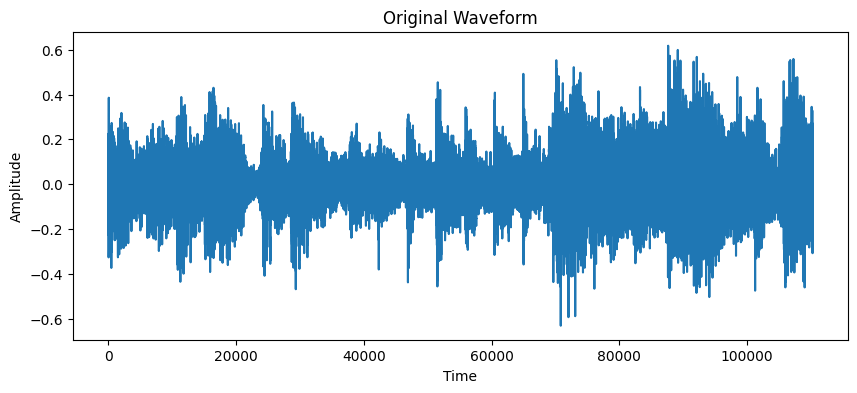

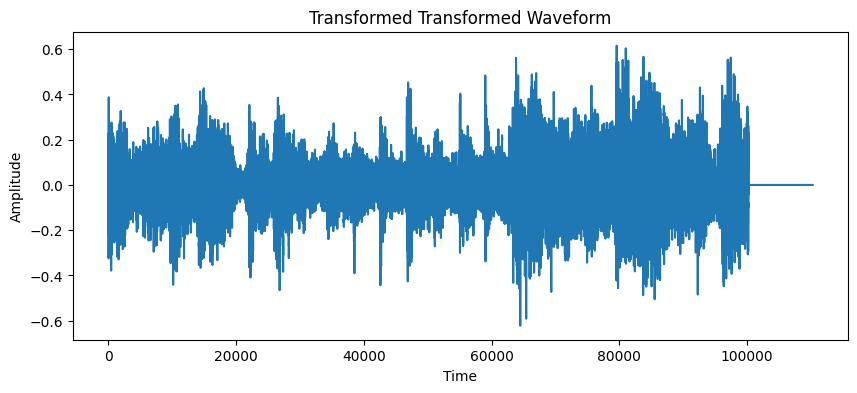

In [ ]:
# Shape de la waveform
print("shape of waveform {}".format(waveform.size()))
print()

# Aplicar transformaciones de entrenamiento en la forma de onda
transformed_waveform = transforms_waveform['train'](waveform)

# Shape de la waveform
print("shape of new waveform {}".format(transformed_waveform.size()))
print()

# Mostrar la forma de onda original
plot_waveform(waveform, samplerate, title="Original Waveform")

# Mostrar la forma de onda transformada
plot_waveform(transformed_waveform, samplerate, title="Transformed Waveform", transformed=True)

In [ ]:
IPython.display.Audio(waveform,rate=samplerate)

In [ ]:
IPython.display.Audio(transformed_waveform,rate=samplerate)

**Spectrogram transform**

shape of spectrogram torch.Size([1, 201, 552])

shape of new spectrogram torch.Size([1, 201, 552])



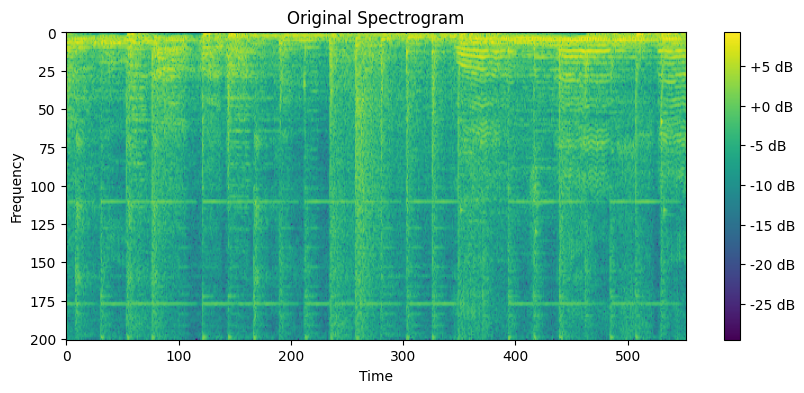

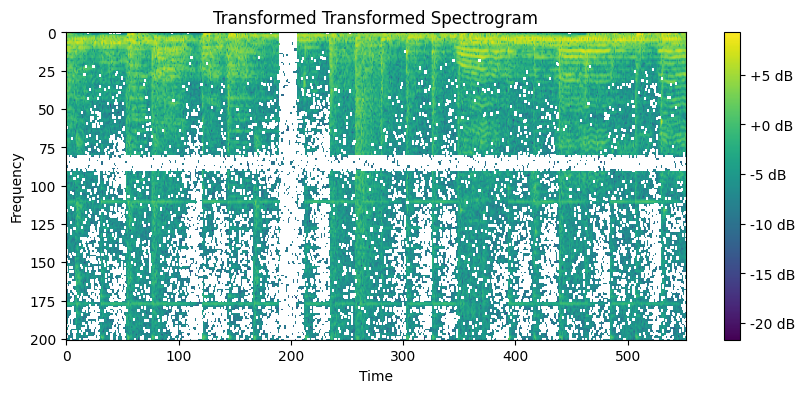

In [ ]:
# Convertir a espectrograma
original_spectrogram = tt.Spectrogram()(waveform)

# Aplicar transformaciones de entrenamiento en el espectrograma
transformed_spectrogram = transforms_spectrogram['train'](waveform)

# Mostrar la forma del espectrograma original
print("shape of spectrogram {}".format(original_spectrogram.size()))
print()

# Mostrar la forma del espectrograma original
print("shape of new spectrogram {}".format(transformed_spectrogram.size()))
print()

# Mostrar el espectrograma original
plot_spectrogram(original_spectrogram[0], title="Original Spectrogram")

# Mostrar el espectrograma transformado
plot_spectrogram(transformed_spectrogram[0], title="Transformed Spectrogram", transformed=True)


## Clasificación **(Prueba de modelos)**

In [13]:
n_input = 110250

##### **Realizamos experimentos variando cantidad de capas densas, nodos y hidden layers**

In [ ]:
# Lista completa de configuraciones de hiperparámetros para MLP2
hyperparameter_configs_MLP2 = [
    {
        "learning_rate": 0.001,
        "batch_size": 32,
        "nodes_list":  [256, 256],
        "dropout_p": 0.0,
        "dense_layers": 4,
        "epochs": 100
    },
    {
        "learning_rate": 0.0005,
        "batch_size": 32,
        "nodes_list":  [512, 512],
        "dropout_p": 0.5,
        "dense_layers": 2,
        "epochs": 100
    },
    {
        "learning_rate": 0.0003,
        "batch_size": 32,
        "nodes_list": [1024, 512, 256],
        "dropout_p": 0.3,
        "dense_layers": 3,
        "epochs": 100
    }
]

**by waveform**

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
if 'dataset' in globals():
    del dataset
    if 'train_dataset' in globals():
        del train_dataset, val_dataset, test_dataset
    if 'train_dataset_s' in globals():
        del train_dataset_s, val_dataset_s, test_dataset_s

gc.collect()

dataset = MusicDataset()

train_dataset_w, val_dataset_w, test_dataset_w = stratify_split(
    dataset,
    dataset.classes,
    transforms_waveform
)


model_name = "MLP2"
train_model_w(model_name, device, hyperparameter_configs_MLP2, dataset, train_dataset_w, val_dataset_w, n_input)


Starting experiment: w_MLP2_epochs_100_opt_adam_scheduler_None_lr_0.0005_nodes_512-512_hl_2_dp_0.3_dl_3
MLP2(
  (dense_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=110250, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
    )
    (1-2): 2 x Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
    )
  )
  (output): Linear(in_features=512, out_features=10, bias=True)
)
Number of parameters: 56982026
Epoch [1/100] - Train Loss: 2.2339, Valid Loss: 2.1515, Accuracy: 0.1889
Epoch [2/100] - Train Loss: 1.7684, Valid Loss: 2.5356, Accuracy: 0.1000
Epoch [3/100] - Train Loss: 1.2970, Valid Loss: 2.7375, Accuracy: 0.1111
Epoch [4/100] - Train Loss: 0.8400, Valid Loss

accuracy,▂▂▄▅▅▄▅▄▄▄▂▄▂▂▁▂▁▁▂▅▄▄▂▂▅▄▁▄▂▅▄▅▄▂▂▄█▇▇▄
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇███
train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▂▂▃▃▃▄▄▄▄▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▇▇▇▇▆▅▆▆▆▇▆█▆▆█
accuracy,0.12222
epoch,100
train_loss,0.00764
valid_loss,7.24681



Starting experiment: w_MLP2_epochs_100_opt_adam_scheduler_None_lr_0.0003_nodes_1024-512-256_hl_3_dp_0.4_dl_4
MLP2(
  (dense_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=110250, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.4, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.4, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.4, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05

accuracy,▁▁▁▁▁▁▁▁▁█▆▆▆▆▆▃▆▃▆▁▆▁▃▁▃▁▁▃▁▃▁▁▁▃▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
train_loss,█▇▇▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▂▃▃▄▄▄▅▅▅▅▅▅▅▆▅▆▆▇▆▅▆▅▇██▇▇▇▆▇▇▇█▇█▇█▇
accuracy,0.1
epoch,100
train_loss,0.0633
valid_loss,7.17368


**by spectrogram**

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
if 'dataset' in globals():
    del dataset
    if 'train_dataset' in globals():
        del train_dataset, val_dataset, test_dataset
    if 'train_dataset_w' in globals():
        del train_dataset_w, val_dataset_w, test_dataset_w

gc.collect()

dataset = MusicDataset()

train_dataset_s, val_dataset_s, test_dataset_s = stratify_split(
    dataset,
    dataset.classes,
    transforms_spectrogram
)

model_name = "MLP2"
train_model_s(model_name, device, hyperparameter_configs_MLP2, dataset, train_dataset_s, val_dataset_s)


Iniciando experimento: s_MLP2_epochs_100_opt_adam_scheduler_None_lr_0.001_nodes_256-256_hl_2_dp_0.2_dl_2
MLP2(
  (dense_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=110250, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (output): Linear(in_features=256, out_features=10, bias=True)
)
Número de parámetros: 28293642


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x110952 and 110250x256)

##### **Extendemos el análisis utilizando capas convolucionales**

In [ ]:
# Configuraciones de hiperparámetros para CEL
hyperparameter_configs_CEL = [
    {
        "learning_rate": 0.001,
        "batch_size": 8,
        "nodes_list": [32, 32],
        "dropout_p": 0.2,
        "dense_layers": 1,
        "epochs": 100
    },
    {
        "learning_rate": 0.0005,
        "batch_size": 16,
        "nodes_list": [64, 64],
        "dropout_p": 0.3,
        "dense_layers": 2,
        "epochs": 100
    },
    {
        "learning_rate": 0.0005,
        "batch_size": 32,
        "nodes_list": [128, 128, 64],
        "dropout_p": 0.3,
        "dense_layers": 2,
        "epochs": 100
    }
]


**by waveform**

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
if 'dataset' in globals():
    del dataset
    if 'train_dataset' in globals():
        del train_dataset, val_dataset, test_dataset
    if 'train_dataset_s' in globals():
        del train_dataset_s, val_dataset_s, test_dataset_s

gc.collect()

dataset = MusicDataset()

train_dataset_w, val_dataset_w, test_dataset_w = stratify_split(
    dataset,
    dataset.classes,
    transforms_waveform
)

model_name = "CEL_w"
train_model_w(model_name, device, hyperparameter_configs_CEL, dataset, train_dataset_w, val_dataset_w, n_input)


**by spectogram**

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
if 'dataset' in globals():
    del dataset
    if 'train_dataset' in globals():
        del train_dataset, val_dataset, test_dataset
    if 'train_dataset_w' in globals():
        del train_dataset_w, val_dataset_w, test_dataset_w

gc.collect()

dataset = MusicDataset()

train_dataset_s, val_dataset_s, test_dataset_s = stratify_split(
    dataset,
    dataset.classes,
    transforms_spectrogram
)

model_name = "CEL_s"
train_model_s(model_name, device, hyperparameter_configs_CEL, dataset, train_dataset_s, val_dataset_s)


wandb: Currently logged in as: luquishh (luquishh-universidad-torcuato-di-tella). Use `wandb login --relogin` to force relogin



Iniciando experimento: s_CEL_s_epochs_100_opt_adam_scheduler_None_lr_0.001_nodes_32-32_hl_2_dp_0.2_dl_1
CEL_s(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.2, inplace=False)
    )
  )
  (dense_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=220800, out_features=10, bias=True)
      (1): Identity()
      (2): Identity()
    )
  )
)

accuracy,▇▄▂▁▁▇▅▅▃▃▃▃▃▄▃▃▅▄▅▅▅▅▅▅▅▄█▅▂▅▆▅▅▅▅▃▂▄▄▅
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▃▁▁▁▂▃▅▄▅▇▅▄▆▅▄▄█▃▇▇▄▂▄▅▄▆▄▅▆▅▇▇█▆▅██▇▆▆
accuracy,0.3
epoch,100
train_loss,0.05286
valid_loss,6.74028



Iniciando experimento: s_CEL_s_epochs_100_opt_adam_scheduler_None_lr_0.0005_nodes_64-64_hl_2_dp_0.3_dl_2
CEL_s(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.3, inplace=False)
    )
  )
  (dense_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=441600, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=Fa

accuracy,▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▅█▅▁▅▅▅▅▅▅
epoch,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
train_loss,▇▇▆▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▆▅▅▅▅█▅▅▅▅▆▄▄▄▄▄▄▃▂▃▄▁
valid_loss,▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅█▅▅▄▅▆▆▅▅▆▆▄█▃▆▅▄▅▃▄▁▃▂▁▁
accuracy,0.11111
epoch,100
train_loss,2.16665
valid_loss,2.24142



Iniciando experimento: s_CEL_s_epochs_100_opt_adam_scheduler_None_lr_0.0005_nodes_128-128-64_hl_3_dp_0.3_dl_2
CEL_s(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.3, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

accuracy,▃▂▁▂▄▃▄▃▄▃▄▅▆▇▃▄▆▅▅▇▆▆▇▃▅▅▅▅▅▄▄▄▆▅▅▅█▆▅▅
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇███
train_loss,███▇█▇▇▇▆▆▅▄▄▄▄▃▄▃▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁
valid_loss,▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▂▁▁▂▃▄▄▃▃▄▄▄▄▅▅▇▇▆█▇▆▆▇
accuracy,0.25556
epoch,100
train_loss,1.20838
valid_loss,2.87519


##### **Realizamos experimentos variando distintas funciones de activación**

In [ ]:
# Configuraciones de hiperparámetros para FA
hyperparameter_configs_FA = [
    {
        "learning_rate": 0.001,
        "batch_size": 8,
        "nodes_list": [32, 32],
        "dropout_p": 0.2,
        "dense_layers": 1,
        "epochs": 100
    },
]

**by waveform**

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
if 'dataset' in globals():
    del dataset
    if 'train_dataset' in globals():
        del train_dataset, val_dataset, test_dataset
    if 'train_dataset_s' in globals():
        del train_dataset_s, val_dataset_s, test_dataset_s

gc.collect()

dataset = MusicDataset()

train_dataset_w, val_dataset_w, test_dataset_w = stratify_split(
    dataset,
    dataset.classes,
    transforms_waveform
)

model_name = 'CEL2_w'
train_model_w(model_name, device, hyperparameter_configs_FA, dataset, train_dataset_w, val_dataset_w, n_input)

model_name = 'CEL3_w'
train_model_w(model_name, device, hyperparameter_configs_FA, dataset, train_dataset_w, val_dataset_w, n_input)


Starting experiment: w_CEL2_w_epochs_100_opt_adam_scheduler_None_lr_0.001_nodes_32-32_hl_2_dp_0.2_dl_1
CEL2_w(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout1d(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout1d(p=0.3, inplace=False)
    )
  )
  (dense_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=881984, out_features=10, bias=True)
      (1): Identity

accuracy,▅▅▁▅▄▆▅▂▄▂▄▅▅▄▆▅▅▄▅▅█▃▃▃▄▄▃▃▃▃▃▃▅▅▄▃▆▅▅▅
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▃▅▄▂▃▃▃▂▃▁▂▂▂▂▃▂▃▁▃▂▂▂▂▃▂▁▂▂▁▁▁▁▁▁▁▁▁▁
valid_loss,▄▅▅▅▅▆█▇▅▇▇█▇▇▇█▇▇▇▇▄▅▇▅▆▄▆▅▃▃▄▃▂▁▁▁▁▁▁▁
accuracy,0.22222
epoch,100
train_loss,0.31375
valid_loss,44.45876



Starting experiment: w_CEL3_w_epochs_100_opt_adam_scheduler_None_lr_0.001_nodes_32-32_hl_2_dp_0.2_dl_1
CEL3_w(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout1d(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout1d(p=0.3, inplace=False)
    )
  )
  (dense_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=881984, out_features=10, bias=True)
      (1): Identity()
      (2): Identity()
    )
 

accuracy,▄▅▅▆▅▆▄▆▅█▃▄▄▄▄▄▇▆▆▄▃▂▄▃▄▁▂▆▄▄▄▃▄▄▃▃▄▄▄▃
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
valid_loss,▁▁▂▂▂▃▂▃▃▃▄▄▃▄▄▄▄▄▄▅▅▅▅▅▆▅▇▇▇▇▇▇▇████▇▇▇
accuracy,0.12222
epoch,100
train_loss,1.1811
valid_loss,336.50417


**by spectogram**

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
if 'dataset' in globals():
    del dataset
    if 'train_dataset' in globals():
        del train_dataset, val_dataset, test_dataset
    if 'train_dataset_w' in globals():
        del train_dataset_w, val_dataset_w, test_dataset_w

gc.collect()

dataset = MusicDataset()

train_dataset_s, val_dataset_s, test_dataset_s = stratify_split(
    dataset,
    dataset.classes,
    transforms_spectrogram
)

model_name = "CEL2_s"
train_model_s(model_name, device, hyperparameter_configs_FA, dataset, train_dataset_s, val_dataset)

model_name = "CEL3_s"
train_model_s(model_name, device, hyperparameter_configs_FA, dataset, train_dataset_s, val_dataset)

##### **Realizar experimentos evaluando distintos optimizadores y schedulers**

In [16]:
# Configuraciones de hiperparámetros para CEL
hyperparameter_configs_OS = [
    {
        "learning_rate": 0.001,
        "batch_size": 8,
        "nodes_list": [32, 32],
        "dropout_p": 0.2,
        "dense_layers": 1,
        "epochs": 30
    },
]
optimizers = ['adam','sgd']
schedulers = ['plateau', 'cosine']

**by waveform**

In [17]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
if 'dataset' in globals():
    del dataset
    if 'train_dataset' in globals():
        del train_dataset, val_dataset, test_dataset
    if 'train_dataset_s' in globals():
        del train_dataset_s, val_dataset_s, test_dataset_s

gc.collect()

dataset = MusicDataset()

train_dataset_w, val_dataset_w, test_dataset_w = stratify_split(
    dataset,
    dataset.classes,
    transforms_waveform
)

model_name = "CEL2_w"


for optimizer_name in optimizers:
    for scheduler_name in schedulers:
        train_model_w(
            model_name=model_name,
            device=device,
            hyperparameter_configs=hyperparameter_configs_OS,
            dataset=dataset,
            train_dataset=train_dataset_w,
            val_dataset=val_dataset_w,
            n_input=n_input,
            scheduler_name=scheduler_name,
            optimizer_name=optimizer_name
        )

wandb: Currently logged in as: luquishh (luquishh-universidad-torcuato-di-tella). Use `wandb login --relogin` to force relogin



Starting experiment: w_CEL2_w_epochs_30_opt_sgd_scheduler_cosine_lr_0.001_nodes_32-32_hl_2_dp_0.2_dl_1
CEL2_w(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout1d(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout1d(p=0.3, inplace=False)
    )
  )
  (dense_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=881984, out_features=10, bias=True)
      (1): Identity

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [2/30] - Train Loss: 2.6535, Valid Loss: 2.2074, Accuracy: 0.1556
Epoch [3/30] - Train Loss: 2.4938, Valid Loss: 2.2506, Accuracy: 0.2000
Epoch [4/30] - Train Loss: 2.1349, Valid Loss: 2.2786, Accuracy: 0.1889
Epoch [5/30] - Train Loss: 1.7573, Valid Loss: 2.5360, Accuracy: 0.2111
Epoch [6/30] - Train Loss: 1.3884, Valid Loss: 2.5269, Accuracy: 0.2111
Epoch [7/30] - Train Loss: 1.1703, Valid Loss: 2.9021, Accuracy: 0.2556
Epoch [8/30] - Train Loss: 1.0929, Valid Loss: 3.0088, Accuracy: 0.2111
Epoch [9/30] - Train Loss: 1.0430, Valid Loss: 3.3904, Accuracy: 0.2222
Epoch [10/30] - Train Loss: 0.9673, Valid Loss: 3.8650, Accuracy: 0.2556
Epoch [11/30] - Train Loss: 0.8002, Valid Loss: 4.1430, Accuracy: 0.2444
Epoch [12/30] - Train Loss: 0.8228, Valid Loss: 5.3295, Accuracy: 0.2889
Epoch [13/30] - Train Loss: 0.8518, Valid Loss: 4.5843, Accuracy: 0.3000
Epoch [14/30] - Train Loss: 0.8061, Valid Loss: 4.3837, Accuracy: 0.2667
Epoch [15/30] - Train Loss: 1.0011, Valid Loss: 3.5311, Acc

accuracy,▁▁▃▃▄▄▆▄▄▆▅██▇▇█▂▆▅▇▆▅▄▄▅▅▅▅▅▄
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▁▁▂▂▂▂▃▄▄▆▅▅▃▄▆▅▇▅▄▅▆█▆▆▇█▆▆
accuracy,0.21111
epoch,30
train_loss,0.30993
valid_loss,5.52196


**by spectogram**

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
if 'dataset' in globals():
    del dataset
    if 'train_dataset' in globals():
        del train_dataset, val_dataset, test_dataset
    if 'train_dataset_w' in globals():
        del train_dataset_w, val_dataset_w, test_dataset_w

gc.collect()

dataset = MusicDataset()

train_dataset_s, val_dataset_s, test_dataset_s = stratify_split(
    dataset,
    dataset.classes,
    transforms_spectrogram
)


model_name = "CEL_s"

# Bucle para entrenar con cada combinación de optimizador y scheduler
for optimizer_name in optimizers:
    for scheduler_name in schedulers:
        # Llamar a la función de entrenamiento
        train_model_s(
            model_name=model_name,
            device=device,
            hyperparameter_configs=hyperparameter_configs_OS,
            dataset=dataset,
            train_dataset=train_dataset_s,
            val_dataset=val_dataset_s,
            scheduler_name=scheduler_name,
            optimizer_name=optimizer_name
        )

##### **Realizar experimentos evaluando distintos batch_sizes y epochs**

In [ ]:
# Configuraciones de hiperparámetros para CEL
hyperparameter_configs_BE = [
    {
        "learning_rate": 0.001,
        "batch_size": 8,
        "nodes_list": [32, 32],
        "dropout_p": 0.2,
        "dense_layers": 1,
        "epochs": 30
    },
    {
        "learning_rate": 0.001,
        "batch_size": 32,
        "nodes_list": [32, 32],
        "dropout_p": 0.2,
        "dense_layers": 1,
        "epochs": 50
    },
]

**by waveform**

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
if 'dataset' in globals():
    del dataset
    if 'train_dataset' in globals():
        del train_dataset, val_dataset, test_dataset
    if 'train_dataset_s' in globals():
        del train_dataset_s, val_dataset_s, test_dataset_s

gc.collect()

dataset = MusicDataset()

train_dataset_w, val_dataset_w, test_dataset_w = stratify_split(
    dataset,
    dataset.classes,
    transforms_waveform
)

model_name = "CEL2_w"

train_model_w(model_name, device, hyperparameter_configs_BE, dataset, train_dataset_w, val_dataset_w, scheduler_name='plateau')

**by spectogram**

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
if 'dataset' in globals():
    del dataset
    if 'train_dataset' in globals():
        del train_dataset, val_dataset, test_dataset
    if 'train_dataset_w' in globals():
        del train_dataset_w, val_dataset_w, test_dataset_w

gc.collect()

dataset = MusicDataset()

train_dataset_s, val_dataset_s, test_dataset_s = stratify_split(
    dataset,
    dataset.classes,
    transforms_spectrogram
)


model_name = "CEL2_s"

train_model_s(model_name, device, hyperparameter_configs_BE, dataset, train_dataset_s, val_dataset_s, scheduler_name='plateau')

##### **Evaluamos algunas técnicas de regularización.**

In [18]:
# Configuraciones de hiperparámetros para CEL
hyperparameter_configs_R = [
    {
        "learning_rate": 0.001,
        "batch_size": 8,
        "nodes_list": [32, 32],
        "dropout_p": 0.2,
        "dense_layers": 1,
        "epochs": 30
    },
]

regularizations = ['l1', 'l2']

**by waveform**

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
if 'dataset' in globals():
    del dataset
    if 'train_dataset' in globals():
        del train_dataset, val_dataset, test_dataset
    if 'train_dataset_s' in globals():
        del train_dataset_s, val_dataset_s, test_dataset_s

gc.collect()

dataset = MusicDataset()

train_dataset_w, val_dataset_w, test_dataset_w = stratify_split(
    dataset,
    dataset.classes,
    transforms_waveform
)

model_name = "CEL2_w"

for i in regularizations:
  train_model_w(model_name, device, hyperparameter_configs_R, dataset, train_dataset_w, val_dataset_w, scheduler_name='cosine', optimizer_name='sgd', n_input=n_input, regularization_type=i)


Starting experiment: w_CEL2_w_epochs_30_opt_sgd_scheduler_cosine_lr_0.001_nodes_32-32_hl_2_dp_0.2_dl_1_reg_l1
CEL2_w(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout1d(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout1d(p=0.3, inplace=False)
    )
  )
  (dense_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=881984, out_features=10, bias=True)
      (1): I

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [2/30] - Train Loss: 12.6707, Valid Loss: 2.3058, Accuracy: 0.1000
Epoch [3/30] - Train Loss: 7.0490, Valid Loss: 2.3023, Accuracy: 0.0889
Epoch [4/30] - Train Loss: 6.5847, Valid Loss: 2.3005, Accuracy: 0.1333
Epoch [5/30] - Train Loss: 6.3543, Valid Loss: 2.2980, Accuracy: 0.1889
Epoch [6/30] - Train Loss: 6.3028, Valid Loss: 2.2975, Accuracy: 0.1333
Epoch [7/30] - Train Loss: 6.1165, Valid Loss: 2.2932, Accuracy: 0.2111
Epoch [8/30] - Train Loss: 5.9763, Valid Loss: 2.2936, Accuracy: 0.1000
Epoch [9/30] - Train Loss: 5.8306, Valid Loss: 2.2978, Accuracy: 0.1111
Epoch [10/30] - Train Loss: 5.5795, Valid Loss: 2.3030, Accuracy: 0.1111
Epoch [11/30] - Train Loss: 5.4869, Valid Loss: 2.2784, Accuracy: 0.0889
Epoch [12/30] - Train Loss: 5.4030, Valid Loss: 2.2980, Accuracy: 0.0333
Epoch [13/30] - Train Loss: 5.2318, Valid Loss: 2.2958, Accuracy: 0.2000
Epoch [14/30] - Train Loss: 5.1873, Valid Loss: 2.2586, Accuracy: 0.1778
Epoch [15/30] - Train Loss: 5.1536, Valid Loss: 2.3056, Ac

accuracy,▄▄▃▅▇▅█▄▄▄▃▁█▇▆▃▄▂▂▄▇▆█▇█▆▅█▄▅
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▅▅▅▅▅▅▅▅▃▅▅▂▅▁▄▄▅▆▂▄▅▄▂▃▃▂▄▃
accuracy,0.14444
epoch,30
train_loss,5.07975
valid_loss,2.2757



Starting experiment: w_CEL2_w_epochs_30_opt_sgd_scheduler_cosine_lr_0.001_nodes_32-32_hl_2_dp_0.2_dl_1_reg_l2
CEL2_w(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout1d(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout1d(p=0.3, inplace=False)
    )
  )
  (dense_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=881984, out_features=10, bias=True)
      (1): I

**by spectrogram**

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
if 'dataset' in globals():
    del dataset
    if 'train_dataset' in globals():
        del train_dataset, val_dataset, test_dataset
    if 'train_dataset_w' in globals():
        del train_dataset_w, val_dataset_w, test_dataset_w

gc.collect()

dataset = MusicDataset()

train_dataset_s, val_dataset_s, test_dataset_s = stratify_split(
    dataset,
    dataset.classes,
    transforms_spectrogram
)


model_name = "CEL_s"

for i in regularizations:
  train_model_s(model_name, device, hyperparameter_configs_R, dataset, train_dataset_s, val_dataset_s, scheduler_name='plateau', regularization_type=i)